!pip install pymorphy2
!pip install sweetviz

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [7]:
df = pd.read_csv('titanicdf.csv')

In [8]:
import sweetviz as sv

my_report = sv.analyze(df)
my_report.show_html() 

                                             |     | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


### Анализируем полученное:
### 1)дубликатов нет
### 2)есть пропуски в колонке Age -177,Cabin-687, Embarked-2 (Cabin колонку, Embarked строки удалим, Age заменим.
### 3) есть колонки с текстом (Name, Sex, Ticket, Embarked ) - преобразовать, но данные по Ticket и Name не коррелируют с Survived, поэтому удалим их.

In [49]:
#df.info()

In [9]:
df.drop_duplicates(inplace=True) #если нужно удалить дубликаты(дубликатов не было)

In [10]:
df = df.drop(['Cabin','Name','Ticket'], axis=1) #удалили колонку Cabin, т.к.  много пропусков, также Name,Ticket, т.к. не влияют на показатель Survived

In [11]:
df

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...,...
886,887,0,2,male,27.0,0,0,13.0000,S
887,888,1,1,female,19.0,0,0,30.0000,S
888,889,0,3,female,NaN,1,2,23.4500,S
889,890,1,1,male,26.0,0,0,30.0000,C


In [19]:
# Меняем пропуски в Age на среднее значение в каждой группе (группировка по Sex и Pclass)
df_grouped = df.groupby(['Pclass','Sex'])['Age'].mean().reset_index().sort_values(by = 'Sex')

In [13]:
df_all = df.merge(df_grouped, how = 'left', on =  ['Pclass','Sex'])

In [14]:
df_all.loc[df_all.Age_x.isna(),'Age_x'] = df_all.Age_y

In [15]:
del df_all['Age_y']

In [16]:
df_all = df_all[~df.Embarked.isna()]#было 2 пропуска в Embarked - удалили 2 строки

In [17]:
#df_all.isna().sum()

In [18]:
#df_all.info()

In [20]:
new_df = pd.get_dummies(data=df_all, columns=['Sex','Embarked']) #преобразовываем текст

In [21]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Age_x        889 non-null    float64
 4   SibSp        889 non-null    int64  
 5   Parch        889 non-null    int64  
 6   Fare         889 non-null    float64
 7   Sex_female   889 non-null    uint8  
 8   Sex_male     889 non-null    uint8  
 9   Embarked_C   889 non-null    uint8  
 10  Embarked_Q   889 non-null    uint8  
 11  Embarked_S   889 non-null    uint8  
dtypes: float64(2), int64(5), uint8(5)
memory usage: 59.9 KB


## Строим модель RandomForestClassifier

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [24]:
X_train, X_test, y_train, y_test = train_test_split(new_df.drop('Survived',axis=1), new_df['Survived'], test_size=0.25, random_state=777)

#### строим модель с параметрами по умолчанию

In [25]:
clf = RandomForestClassifier()

In [26]:
model = clf.fit(X_train, y_train)

In [27]:
pred = model.predict(X_test)

In [33]:
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [29]:
print('Precision:',precision_score(y_test,pred))
print('Recall:',recall_score(y_test,pred))
print('F1:',f1_score(y_test,pred))


Precision: 0.855072463768116
Recall: 0.6210526315789474
F1: 0.7195121951219512


#### строим модель2 с заданными параметрами (просто наугад)

In [30]:
clf2 = RandomForestClassifier(n_estimators=50, criterion='entropy', max_depth=5)

In [31]:
model2 = clf2.fit(X_train, y_train)
pred2 = model2.predict(X_test)

In [32]:
print('Precision:',precision_score(y_test,pred2))
print('Recall:',recall_score(y_test,pred2))
print('F1:',f1_score(y_test,pred2))
# с заданными параметрами значения метрик получились ниже, поэтому будем подбирать параметры 

Precision: 0.8285714285714286
Recall: 0.6105263157894737
F1: 0.703030303030303


## ROC-AUC

In [34]:
model.predict(X_test)

array([1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0], dtype=int64)

In [35]:
model.predict_proba(X_test)[:,1]

array([0.69, 0.94, 0.12, 0.36, 0.31, 0.07, 0.33, 0.62, 0.3 , 0.21, 0.19,
       0.97, 0.23, 0.02, 0.28, 0.01, 0.04, 0.98, 0.24, 0.51, 0.29, 0.83,
       0.  , 0.29, 0.03, 0.59, 0.15, 0.01, 0.06, 0.07, 0.02, 0.05, 0.33,
       0.03, 0.03, 0.76, 0.73, 0.85, 0.34, 0.05, 0.04, 0.11, 0.1 , 0.69,
       0.01, 0.82, 0.03, 0.08, 0.57, 0.09, 0.05, 0.41, 0.02, 0.74, 0.21,
       0.07, 0.21, 0.12, 0.06, 0.77, 0.97, 0.03, 0.88, 0.12, 0.02, 0.12,
       0.02, 0.9 , 0.98, 0.08, 0.71, 0.05, 0.93, 0.99, 0.56, 0.34, 0.58,
       0.19, 0.64, 0.34, 0.94, 0.37, 0.8 , 0.15, 0.25, 0.03, 0.74, 0.06,
       0.22, 0.99, 0.14, 0.02, 0.  , 0.84, 0.02, 0.03, 0.98, 0.44, 0.84,
       0.19, 0.35, 0.81, 0.47, 0.28, 0.08, 0.21, 0.03, 0.  , 0.53, 0.93,
       0.  , 0.33, 0.08, 0.1 , 0.12, 0.01, 0.48, 0.45, 0.51, 0.01, 0.55,
       0.96, 0.12, 0.06, 0.99, 0.16, 0.04, 0.12, 0.  , 0.1 , 0.98, 0.96,
       0.96, 0.08, 0.17, 0.96, 0.07, 0.19, 0.22, 1.  , 0.09, 0.02, 0.48,
       0.78, 0.09, 0.38, 0.13, 0.04, 0.43, 0.04, 0.

In [36]:
pred_proba = model.predict_proba(X_test)[:,1]

In [37]:
fpr, tpr, treshold = roc_curve(y_test, pred_proba)
tree_auc = roc_auc_score(y_test, pred_proba)
print('RandomForestClassifier: ROC AUC=%.3f' % (tree_auc))

RandomForestClassifier: ROC AUC=0.865


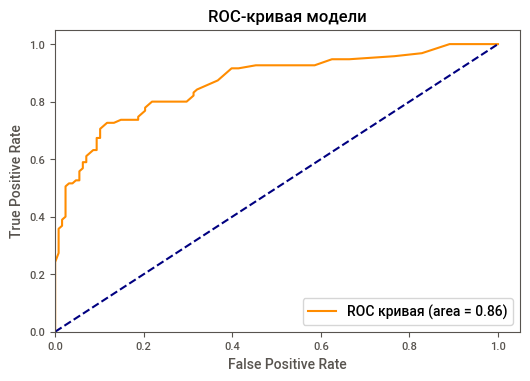

In [38]:
roc_auc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr,  color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая модели')
plt.legend(loc="lower right")
plt.show()


### Показатель ROC-кривой говорит о высоком качестве классификатора модели. Чем выше площадь под кривой, тем лучше производительность модели.

### Подбираем наилучшие параметры

In [231]:
from sklearn.model_selection import GridSearchCV

In [233]:
tree_para = {'n_estimators':[100,130,150,170,190,200,250],
             'criterion':['gini','entropy'],
             'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30]}

In [234]:
clf_gs = GridSearchCV(RandomForestClassifier(), tree_para, cv=10, scoring = 'recall')
clf_gs.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20,
                                       30],
                         'n_estimators': [100, 130, 150, 170, 190, 200, 250]},
             scoring='recall')

In [235]:
clf_gs.best_params_ #лучшие параметры для оценки 'recall'

{'criterion': 'gini', 'max_depth': 5, 'n_estimators': 130}

In [208]:
clf_gs2 = GridSearchCV(RandomForestClassifier(), tree_para, cv=10, scoring = 'precision')
clf_gs2.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30,
                                       40, 50, 70, 90, 120, 150],
                         'n_estimators': [100, 110, 120, 130, 140, 150, 160,
                                          170, 180, 190, 200]},
             scoring='precision')

In [209]:
clf_gs2.best_params_ # лучшие параметры для оценки 'presicion'

{'criterion': 'gini', 'max_depth': 7, 'n_estimators': 200}

### Модель с новыми параметрами

In [236]:
model_new = RandomForestClassifier(**clf_gs.best_params_)

In [237]:
model_new.fit(X_train,y_train)

RandomForestClassifier(max_depth=5, n_estimators=130)

In [238]:
new_pred = model_new.predict(X_test)

In [239]:
print('Precision:',precision_score(y_test,new_pred))
print('Recall:',recall_score(y_test,new_pred))
print('F1:',f1_score(y_test,new_pred))

Precision: 0.8656716417910447
Recall: 0.6105263157894737
F1: 0.7160493827160493


In [214]:
model_new2 = RandomForestClassifier(**clf_gs2.best_params_)

In [215]:
model_new2.fit(X_train,y_train)

RandomForestClassifier(max_depth=7, n_estimators=200)

In [216]:
new_pred2 = model_new2.predict(X_test)

In [217]:
print('Precision:',precision_score(y_test,new_pred2))
print('Recall:',recall_score(y_test,new_pred2))
print('F1:',f1_score(y_test,new_pred2))

Precision: 0.8461538461538461
Recall: 0.5789473684210527
F1: 0.6875


## Вывод: при подборе параметров значения метрик получились ниже, чем в модели с параметрами по умолчанию???

## Кросс-валидация модели model с параметрами по умолчанию

In [218]:
cv = ShuffleSplit(n_splits=10, test_size=0.25, random_state=242)
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='precision')

In [220]:
scores.mean() #средний показатель метрики 'precision'

0.8068803248365294

In [221]:
scores

array([0.84615385, 0.72413793, 0.81481481, 0.9       , 0.71111111,
       0.78333333, 0.77966102, 0.875     , 0.76666667, 0.86792453])

In [225]:
cv = ShuffleSplit(n_splits=10, test_size=0.25, random_state=242)
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='recall')

In [226]:
scores.mean() #средний показатель метрики 'recall'

0.7164021391100522

In [227]:
scores

array([0.68181818, 0.71929825, 0.77586207, 0.73972603, 0.62      ,
       0.66197183, 0.81355932, 0.71428571, 0.703125  , 0.734375  ])

In [228]:
cv = ShuffleSplit(n_splits=10, test_size=0.25, random_state=242)
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')

In [229]:
scores.mean() #средний показатель метрики 'f1'

0.7516593583856943

In [230]:
scores

array([0.72881356, 0.71186441, 0.77192982, 0.81481481, 0.68041237,
       0.73282443, 0.7768595 , 0.77876106, 0.73770492, 0.7826087 ])

### Еще пробуем подобрать параметры

In [39]:
test_deep = []
for deep in range (1,31):
    for estimator in range (100,200):
        clf =  RandomForestClassifier(max_depth=deep, n_estimators=estimator)
        model = clf.fit(X_train, y_train)
        pred = model.predict(X_test)
        test_deep.append([deep, estimator, precision_score(y_test,pred),recall_score(y_test,pred),f1_score(y_test,pred)])

In [40]:
test_deep = pd.DataFrame(test_deep)
test_deep.columns = ['max_depth','n_estimators','precision_score','recall_score','f1_score']

In [41]:
test_deep.sort_values(by='precision_score',ascending=False).head(10)

,max_depth,n_estimators,precision_score,recall_score,f1_score
606,7,106,0.948276,0.578947,0.718954
46,1,146,0.936170,0.463158,0.619718
63,1,163,0.933333,0.442105,0.600000
509,6,109,0.931034,0.568421,0.705882
604,7,104,0.931034,0.568421,0.705882
642,7,142,0.920635,0.610526,0.734177
436,5,136,0.918033,0.589474,0.717949
504,6,104,0.916667,0.578947,0.709677
610,7,110,0.916667,0.578947,0.709677
59,1,159,0.916667,0.463158,0.615385


In [248]:
test_deep.sort_values(by='recall_score',ascending=False).head(10)

,max_depth,n_estimators,precision_score,recall_score,f1_score
1226,13,126,0.863014,0.663158,0.750000
2403,25,103,0.851351,0.663158,0.745562
2943,30,143,0.840000,0.663158,0.741176
1817,19,117,0.863014,0.663158,0.750000
2919,30,119,0.851351,0.663158,0.745562
2826,29,126,0.840000,0.663158,0.741176
1115,12,115,0.863014,0.663158,0.750000
2970,30,170,0.840000,0.663158,0.741176
1609,17,109,0.851351,0.663158,0.745562
2645,27,145,0.840000,0.663158,0.741176


In [249]:
test_deep.sort_values(by='f1_score',ascending=False).head(10)

,max_depth,n_estimators,precision_score,recall_score,f1_score
2249,23,149,0.875000,0.663158,0.754491
1817,19,117,0.863014,0.663158,0.750000
1115,12,115,0.863014,0.663158,0.750000
1226,13,126,0.863014,0.663158,0.750000
1244,13,144,0.873239,0.652632,0.746988
1956,20,156,0.873239,0.652632,0.746988
1313,14,113,0.873239,0.652632,0.746988
2188,22,188,0.873239,0.652632,0.746988
1609,17,109,0.851351,0.663158,0.745562
1726,18,126,0.851351,0.663158,0.745562


In [42]:
# Строим модель, ориентируясь на метрику precision_score
clf3 = RandomForestClassifier(n_estimators=106, criterion='entropy', max_depth=7)
model3= clf3.fit(X_train, y_train)
pred3 = model3.predict(X_test) 

In [43]:
print('Precision:',precision_score(y_test,pred3))
print('Recall:',recall_score(y_test,pred3))
print('F1:',f1_score(y_test,pred3))

Precision: 0.9137931034482759
Recall: 0.5578947368421052
F1: 0.6928104575163399


In [44]:
clf3 = RandomForestClassifier(n_estimators=106, criterion='gini', max_depth=7)
model3= clf3.fit(X_train, y_train)
pred3 = model3.predict(X_test)

In [45]:
print('Precision:',precision_score(y_test,pred3))
print('Recall:',recall_score(y_test,pred3))
print('F1:',f1_score(y_test,pred3))

Precision: 0.8870967741935484
Recall: 0.5789473684210527
F1: 0.7006369426751592


### Вывод: при подборе параметров (n_estimators=106, criterion='entropy', max_depth=7), ориентируясь на метрику Precision, model3 имеет максимальное значение данной метрики.